In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Exploratory Data Analysis (EDA) of Cloud Microphysics Constraints

In this notebook, we perform some data exploration analysis to justify the two microphysics constraints used in "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation", Hu et al. 2024, arXiv preprint:2306.08754.

## Set data path

All the simulation output, saved model weights, and preprocessed data used in Hu et al. 2024 "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation" are provided in a hu_etal2024_data folder that you can download. Please change the following path to your downloaded hu_etal2024_data folder.

In [3]:
data_path = '/global/homes/z/zeyuanhu/scratch/hu_etal2024_data/'

## 1. Cloud liquid-ice partition is controlled by temperature

Here we read in one-year hourly data from E3SM mmf reference simulation.

In [4]:
ds_sp_h2 = xr.open_dataset(data_path+'microphysics_hourly/liq_partition_control_fullysp_jan_wmlio_r3.eam.h2.0003.nc')


In the cloud-resolving model SAM, it uses a one-moment microphysics scheme. On each SAM grid, the cloud liquid and ice are diagnosed based on temperature, as described by the "apply_rules" function below and is shown in the Figure a below. This is hardcoded in SAM's code. 

In [5]:
def apply_rules(T):
    # Create an output array with the same shape as T initialized with zeros
    result = xr.zeros_like(T)
    
    # Apply the condition for T < 253.16
    result = xr.where(T < 253.16, 0, result)
    
    # Apply the condition for T > 273.16
    result = xr.where(T > 273.16, 1, result)
    
    # Linearly transit from 0 to 1 for T within (253.16, 273.16)
    result = xr.where((T >= 253.16) & (T <= 273.16), (T - 253.16) / (273.16 - 253.16), result)
    
    return result

Now let's compare the liquid cloud fraction (i.e., liquid/(liquid+ice)) on the actual E3SM grid versus the predicted fraction using E3SM grid's temperature:

In [7]:
ratio_sam = apply_rules(ds_sp_h2.T)
ratio_e3sm = ds_sp_h2.CLDLIQ/(ds_sp_h2.CLDLIQ + ds_sp_h2.CLDICE)

sampling_freq = 1
t_sub = ds_sp_h2.T[::sampling_freq].values.flatten()
ratio_sam_sub = ratio_sam[::sampling_freq].values.flatten()
ratio_e3sm_sub = ratio_e3sm[::sampling_freq].values.flatten()
qc_sub = ds_sp_h2.CLDLIQ[::sampling_freq].values.flatten()
qi_sub = ds_sp_h2.CLDICE[::sampling_freq].values.flatten()
qn_sub = qc_sub+qi_sub

In [8]:
# Filtering data to remove very small values
sam_values = ratio_sam_sub[qn_sub > 1e-12]
e3sm_values = ratio_e3sm_sub[qn_sub > 1e-12]

x_edges = np.linspace(0, 1, 41, endpoint=True)
y_edges = np.linspace(0, 1, 41, endpoint=True)

# Compute the 2D histogram
histogram, x_edges, y_edges = np.histogram2d(sam_values, e3sm_values, bins=(x_edges, y_edges))


/tmp/ipykernel_2270070/2711871604.py:12: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax1.contourf(X, Y, histogram, levels=15, cmap='plasma', norm=LogNorm())


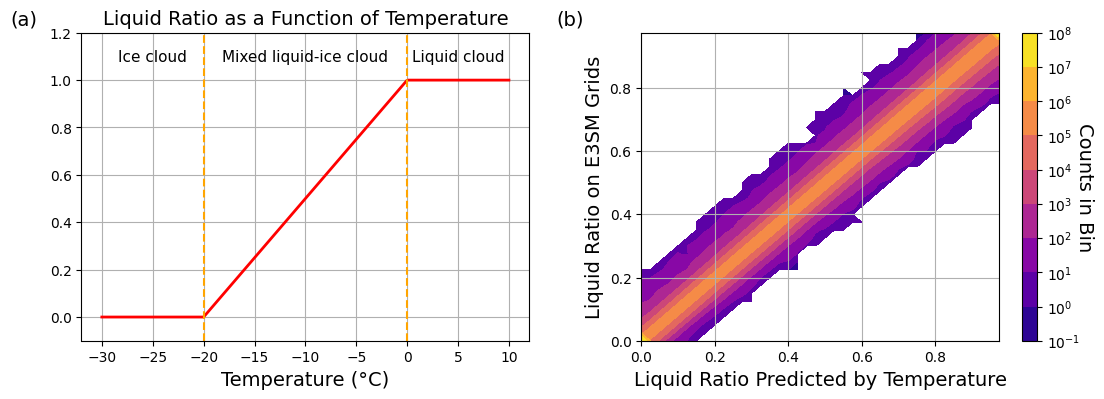

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Create a figure and a set of subplots
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(13, 4))

# First subplot for the 2D histogram
X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1], indexing="ij")
# contour = ax1.contourf(X, Y, np.log10(histogram + 1), levels=15, cmap='viridis')
# fig.colorbar(contour, ax=ax1, label='Log of counts in bin')
contour = ax1.contourf(X, Y, histogram, levels=15, cmap='plasma', norm=LogNorm())
cbar = fig.colorbar(contour, ax=ax1, label='Log of counts in bin')
cbar.set_label('Counts in Bin', rotation=270, labelpad=10, fontsize=14)

ax1.set_xlabel('Liquid Ratio Predicted by Temperature', fontsize=14)
ax1.set_ylabel('Liquid Ratio on E3SM Grids', fontsize=14)
ax1.set_title('', fontsize=14)
ax1.grid(True)

# Second subplot for the piecewise function
def piecewise_function(x):
    if x > 0:
        return 1
    elif x < -20:
        return 0
    else:
        return (x + 20) / 20

x_values = np.linspace(-30, 10, 400)
y_values = [piecewise_function(x) for x in x_values]

ax2.plot(x_values, y_values, color='red', linewidth=2)
ax2.set_title('Liquid Ratio as a Function of Temperature', fontsize=14)
ax2.set_xlabel('Temperature (°C)', fontsize=14)
ax2.set_ylabel('')
ax2.grid(True)
ax2.set_ylim(-0.1, 1.2)

# Add vertical lines and text annotations
ax2.axvline(x=-20, color='orange', linestyle='--')
ax2.axvline(x=0, color='orange', linestyle='--')
ax2.text(-25, 1.1, 'Ice cloud', verticalalignment='center', horizontalalignment='center', fontsize=11)
ax2.text(-10, 1.1, 'Mixed liquid-ice cloud', verticalalignment='center', horizontalalignment='center', fontsize=11)
ax2.text(5, 1.1, 'Liquid cloud', verticalalignment='center', horizontalalignment='center', fontsize=11)

# Adjust layout to add more space between panels
plt.subplots_adjust(wspace=0.25)  # Adjust the width space between subplots
fig.text(0.07, 0.9, '(a)', fontsize=14, transform=fig.transFigure)
fig.text(0.49, 0.9, '(b)', fontsize=14, transform=fig.transFigure)

plt.show()


We can see that in the panel b above, on most E3SM grids the actual liquid ratio follows the temperature-based prediction well (as most grids are located on the lower left corner, diagonal, or the upper right corner). This motivate us to only predict total water and then use temperature to diagnose cloud liquid and ice separately.

## 2. Suppress clouds above tropopause

In "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation" paper (Hu et al. 2024), we showed that in online simulations, the NN can generate excessive clouds in the stratosphere and explode the model. By physics, we know these clouds are rare and mostly form due to deep penetrating convection. For maintaining the online stability, we identify a tropopause level using p<400hPa and dtheta/dt>10 K/km and eliminate all clouds above the tropopause level at every model time step. Below we show that the distribution of cloud top level is indeed capped by our defined tropopause level most of the time (but not always). 

In [10]:
ds_nn_o = xr.open_dataset(data_path+'microphysics_hourly/control_fullysp_jan_wmlio_r3_tropopause.eam.h2.qn_mlo-0003.nc')
ds_nn_h2 = xr.open_dataset(data_path+'microphysics_hourly/tropopause-control_fullysp_jan_wmlio_r3_tropopause-0003.nc')


In [12]:
ps = ds_nn_h2['PS']
pmid = ds_nn_h2.hybm*ps + ds_nn_h2.hyam*ds_nn_h2['P0']
pmid = np.transpose(pmid.values, (1, 0, 2))
T = ds_nn_h2['T']
theta = T * (1e5/pmid)**(287./1005.)
z3 = ds_nn_h2['Z3']

dthetadz = xr.zeros_like(theta)
dthetadz[:,1:-1,:] = (theta[:, :-2, :].values - theta[:, 2:, :].values) / (z3[:, :-2, :].values - z3[:, 2:, :].values)
dthetadz[:,0,:] =  (theta[:, 0, :].values - theta[:, 1, :].values) / (z3[:, 0, :].values - z3[:, 1, :].values)
dthetadz[:,-1,:] =  (theta[:, -2, :].values - theta[:, -1, :].values) / (z3[:, -2, :].values - z3[:, -1, :].values)

qn_next= ds_nn_o['qn_next_tmp']

In [13]:
dthetadz.shape, qn_next.shape, pmid.shape #note that the data dimension is currently (num_time_steps, num_levels, num_columns)

((8759, 60, 384), (8759, 60, 384), (8759, 60, 384))

Construct the cloud top levels defined as the level the first grid (from top to bottom) that exceeds a threshold of 1e-6 kg/kg. For comparison, we also calculate the cloud top level based on the threshold value of 1e-7 kg/kg.

In [16]:
mask = qn_next > 1e-7

# Use 'argmax' along the 'level' dimension to find the first level where condition is True
first_true_indices = mask.argmax(dim='lev', skipna=True)

# Check where any True exists to differentiate between actual index 0 and no True values
any_true = mask.any(dim='lev')

# Using 'where' to filter out places with no True values
first_true_indices = first_true_indices.where(any_true, np.nan)  # Replace with -1 where no True values are found
first_true_indices_qne7 = first_true_indices.compute()

mask = qn_next > 1e-6

# Use 'argmax' along the 'level' dimension to find the first level where condition is True
first_true_indices = mask.argmax(dim='lev', skipna=True)

# Check where any True exists to differentiate between actual index 0 and no True values
any_true = mask.any(dim='lev')

# Using 'where' to filter out places with no True values
first_true_indices = first_true_indices.where(any_true, np.nan)  # Replace with -1 where no True values are found
first_true_indices_qne6 = first_true_indices.compute()

Construct the tropopause level defined as the lowest level that satisfied p<400hPa and dtheta/dt>10 K/km.

In [18]:
mask = xr.where((pmid < 40000) & (dthetadz * 1000 > 10), True, False)
reversed_mask = mask[:,::-1,:]
reversed_first_true_indices = reversed_mask.argmax(dim='lev', skipna=True)
last_true_indices = (mask.lev.size - 1) - reversed_first_true_indices
first_true_indices = last_true_indices

# Check where any True exists to differentiate between actual index 0 and no True values
any_true = mask.any(dim='lev')

# Using 'where' to filter out places with no True values
first_true_indices = first_true_indices.where(any_true,np.nan)  # Replace with -1 where no True values are found
first_true_indices_p400_t10 = first_true_indices.compute()

### Plotting the 2d histogram of tropopause level vs cloud top level

/tmp/ipykernel_2270070/2437838606.py:21: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contourf(X[:-1, :-1], Y[:-1, :-1], H.T, levels=100, cmap='Blues', norm=norm)


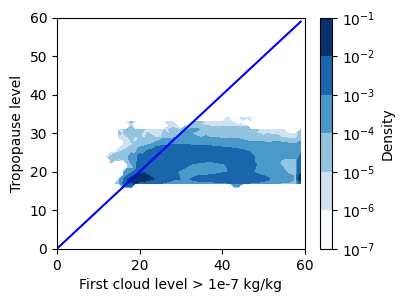

In [19]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots(figsize=(4, 3))
first_true_indices_qne7_tmp = np.where(np.isnan(first_true_indices_qne7), 59, first_true_indices_qne7)
first_true_indices_p400_t10_tmp = np.where(np.isnan(first_true_indices_p400_t10), 0, first_true_indices_p400_t10)

bins = np.arange(0, 61, 1)

# Generate the 2D histogram
H, xedges, yedges = np.histogram2d(
    first_true_indices_qne7_tmp.flatten(),
    first_true_indices_p400_t10_tmp.flatten(),
    bins=[bins, bins],
    density=True
)

# Create the meshgrid for the edges
X, Y = np.meshgrid(xedges, yedges)

# Generate the contour plot with a logarithmic color scale
norm = mcolors.LogNorm(vmin=H[H > 0].min(), vmax=H.max())
cs = ax.contourf(X[:-1, :-1], Y[:-1, :-1], H.T, levels=100, cmap='Blues', norm=norm)

# Add a colorbar
cb = fig.colorbar(cs, ax=ax)
cb.set_label('Density')

# Plot the diagonal line
ax.plot(np.arange(60), np.arange(60), color='blue')

# Set the limits and labels
ax.set_xlim(0, 60)
ax.set_ylim(0, 60)
ax.set_xlabel('First cloud level > 1e-7 kg/kg')
ax.set_ylabel('Tropopause level')

# Show the plot
plt.show()

/tmp/ipykernel_2270070/3491987018.py:20: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contourf(X[:-1, :-1], Y[:-1, :-1], H.T, levels=100, cmap='Blues', norm=norm)


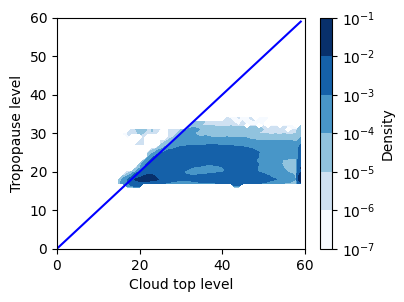

In [20]:
fig, ax = plt.subplots(figsize=(4, 3))
first_true_indices_qne6_tmp = np.where(np.isnan(first_true_indices_qne6), 59, first_true_indices_qne6)
first_true_indices_p400_t10_tmp = np.where(np.isnan(first_true_indices_p400_t10), 0, first_true_indices_p400_t10)

bins = np.arange(0, 61, 1)

# Generate the 2D histogram
H, xedges, yedges = np.histogram2d(
    first_true_indices_qne6_tmp.flatten(),
    first_true_indices_p400_t10_tmp.flatten(),
    bins=[bins, bins],
    density=True
)

# Create the meshgrid for the edges
X, Y = np.meshgrid(xedges, yedges)

# Generate the contour plot with a logarithmic color scale
norm = mcolors.LogNorm(vmin=H[H > 0].min(), vmax=H.max())
cs = ax.contourf(X[:-1, :-1], Y[:-1, :-1], H.T, levels=100, cmap='Blues', norm=norm)

# Add a colorbar
cb = fig.colorbar(cs, ax=ax)
cb.set_label('Density')

# Plot the diagonal line
ax.plot(np.arange(60), np.arange(60), color='blue')

# Set the limits and labels
ax.set_xlim(0, 60)
ax.set_ylim(0, 60)
ax.set_xlabel('Cloud top level')
ax.set_ylabel('Tropopause level')

# Show the plot
plt.show()

We can see that most cloudy grids above our defined tropopause are below 1e-6 kg/kg. 